# Kernel Usage Regularization

In [39]:
%matplotlib inline

In [1]:
import tensorflow as tf

## Setup

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np

## Model

In [8]:
kur_model = tf.keras.models.load_model('/tf/logs/sdumont/classification/voc07/rn101-randaug/kur/6/saved_model')

The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [13]:
kur_model.summary()

Model: "ml_voc07"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 512, 512, 3)]     0         
                                                                 
 resnet101v2 (Functional)    (None, 2048)              42626560  
                                                                 
 head/drop (Dropout)         (None, 2048)              0         
                                                                 
 head/logits (DenseKU)       (None, 20)                40980     
                                                                 
 head/predictions (Activatio  (None, 20)               0         
 n)                                                              
                                                                 
Total params: 42,667,540
Trainable params: 27,257,876
Non-trainable params: 15,409,664
_____________________________________

In [20]:
x = tf.ones((4, 2048))

In [23]:
dense_kur = kur_model.layers[-2]

y = dense_kur(x)

In [22]:
y

<tf.Tensor: shape=(4, 20), dtype=float16, numpy=
array([[-11.81 ,  -8.77 ,  -6.574,  -9.71 ,  -7.35 ,  -9.66 ,  -6.055,
         -7.26 ,  -7.133,  -9.766, -10.43 ,  -3.084,  -9.15 ,  -8.01 ,
         -0.27 ,  -8.4  ,  -8.09 ,  -9.12 , -11.68 ,  -9.97 ],
       [-11.81 ,  -8.77 ,  -6.574,  -9.71 ,  -7.35 ,  -9.66 ,  -6.055,
         -7.26 ,  -7.133,  -9.766, -10.43 ,  -3.084,  -9.15 ,  -8.01 ,
         -0.27 ,  -8.4  ,  -8.09 ,  -9.12 , -11.68 ,  -9.97 ],
       [-11.81 ,  -8.77 ,  -6.574,  -9.71 ,  -7.35 ,  -9.66 ,  -6.055,
         -7.26 ,  -7.133,  -9.766, -10.43 ,  -3.084,  -9.15 ,  -8.01 ,
         -0.27 ,  -8.4  ,  -8.09 ,  -9.12 , -11.68 ,  -9.97 ],
       [-11.81 ,  -8.77 ,  -6.574,  -9.71 ,  -7.35 ,  -9.66 ,  -6.055,
         -7.26 ,  -7.133,  -9.766, -10.43 ,  -3.084,  -9.15 ,  -8.01 ,
         -0.27 ,  -8.4  ,  -8.09 ,  -9.12 , -11.68 ,  -9.97 ]],
      dtype=float16)>

In [30]:
kernel = dense_kur.weights[0]
ag = kernel
ag = ag - tf.reduce_max(ag, axis=-1, keepdims=True)
ag = tf.nn.softmax(ag)
ag *= 20

<tf.Tensor: shape=(4, 20), dtype=float16, numpy=
array([[-11.81 ,  -8.77 ,  -6.574,  -9.71 ,  -7.35 ,  -9.66 ,  -6.055,
         -7.26 ,  -7.133,  -9.766, -10.43 ,  -3.084,  -9.15 ,  -8.01 ,
         -0.27 ,  -8.4  ,  -8.09 ,  -9.12 , -11.68 ,  -9.97 ],
       [-11.81 ,  -8.77 ,  -6.574,  -9.71 ,  -7.35 ,  -9.66 ,  -6.055,
         -7.26 ,  -7.133,  -9.766, -10.43 ,  -3.084,  -9.15 ,  -8.01 ,
         -0.27 ,  -8.4  ,  -8.09 ,  -9.12 , -11.68 ,  -9.97 ],
       [-11.81 ,  -8.77 ,  -6.574,  -9.71 ,  -7.35 ,  -9.66 ,  -6.055,
         -7.26 ,  -7.133,  -9.766, -10.43 ,  -3.084,  -9.15 ,  -8.01 ,
         -0.27 ,  -8.4  ,  -8.09 ,  -9.12 , -11.68 ,  -9.97 ],
       [-11.81 ,  -8.77 ,  -6.574,  -9.71 ,  -7.35 ,  -9.66 ,  -6.055,
         -7.26 ,  -7.133,  -9.766, -10.43 ,  -3.084,  -9.15 ,  -8.01 ,
         -0.27 ,  -8.4  ,  -8.09 ,  -9.12 , -11.68 ,  -9.97 ]],
      dtype=float16)>

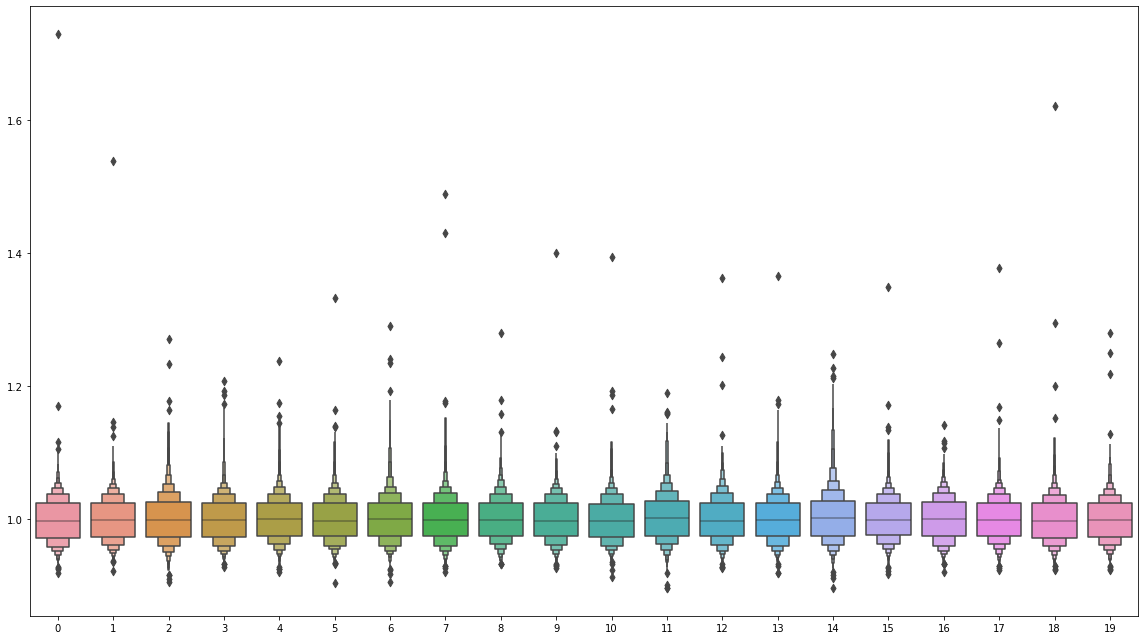

In [48]:
plt.figure(figsize=(16, 9))
sns.boxenplot(data=ag)
plt.tight_layout();

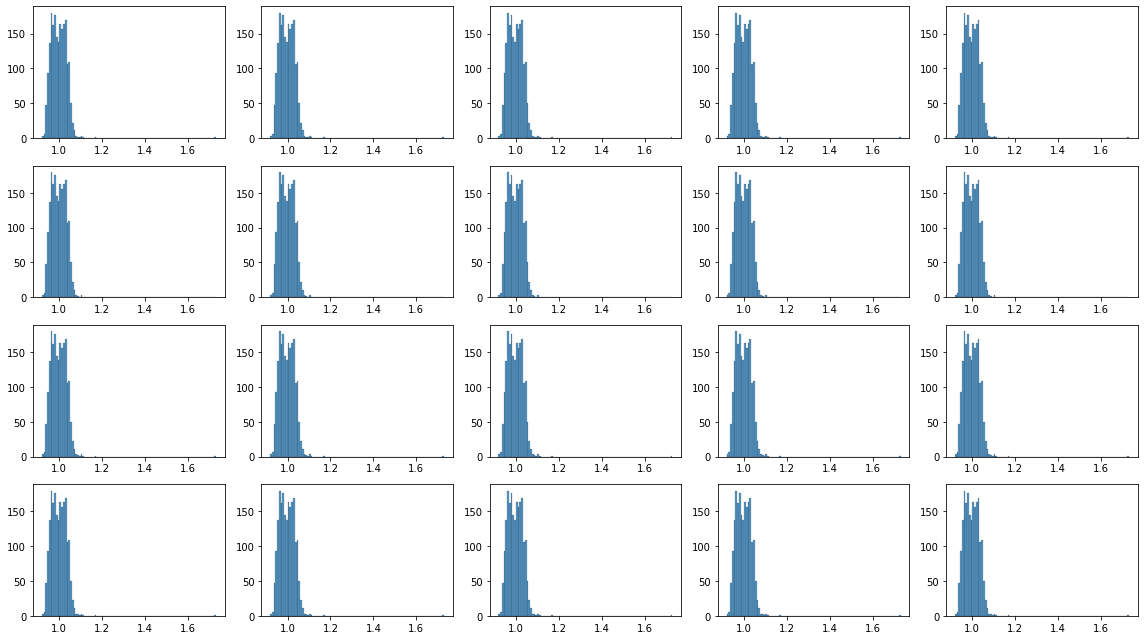

In [42]:
plt.figure(figsize=(16, 9))

for i in range(20):
    plt.subplot(4, 5, i+1)
    sns.histplot(ag[:, 0].numpy())
    plt.ylabel(None)

plt.tight_layout();

## Visualization Maps

In [68]:
preprocess = tf.keras.applications.resnet_v2.preprocess_input

In [55]:
import tensorflow_datasets as tfds

(val_dataset,), info = tfds.load(
  'voc/2007',
  split=('validation',),
  with_info=True,
  shuffle_files=False,
  data_dir='/tf/data'
)

In [59]:
CLASSES = np.asarray(info.features['objects']['label']._int2str)
int2str = info.features['objects']['label'].int2str

In [74]:
from functools import partial


@tf.function
def load_fn(d, augment=False):
  image = d['image']
  labels = d['objects']['label']

  image = tf.cast(image, tf.float32)
  
  image, reduction_ratio, pad_ratio = adjust_resolution(image)
  image = preprocess(image)

  return image, labels_to_one_hot(labels), d['objects']['bbox'] * [pad_ratio[0], pad_ratio[1], pad_ratio[0], pad_ratio[1]]


def adjust_resolution(image):
  es = tf.constant([512, 512], tf.float32)
  xs = tf.cast(tf.shape(image)[:2], tf.float32)

  ratio = tf.reduce_min(es / xs)
  xsn = tf.math.ceil(ratio * xs)

  image = tf.image.resize(image, tf.cast(xsn, tf.int32), preserve_aspect_ratio=True, method='nearest')

  return image, ratio, xsn/es


def labels_to_one_hot(labels):
  return tf.reduce_max(
    tf.one_hot(labels, depth=CLASSES.shape[0]),
    axis=0
  )

def prepare(ds, batch_size, cache=False, shuffle=False, augment=False):
  if cache: ds = ds.cache()

  return (ds.map(partial(load_fn, augment=augment), num_parallel_calls=tf.data.AUTOTUNE)
            .padded_batch(batch_size, padding_values=0., padded_shapes=([512, 512, 3], [20], [None, 4]), drop_remainder=True)
            .prefetch(tf.data.AUTOTUNE))

In [75]:
valid = prepare(val_dataset, 16)

#### Raw Segmentation Maps

In [91]:
nn_s = tf.keras.Model(
  inputs=kur_model.inputs,  
  outputs=[kur_model.layers[1].get_layer('avg_pool').input, kur_model.output]
)

In [ ]:
nn_s(tf.random.normal((16, 512, 512, 3)));

In [78]:
def create_pascal_label_colormap():
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)
  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap

def label_to_color_image(label):
  if label.ndim != 2: raise ValueError('Expect 2-D input label')
  if np.max(label) >= len(C): raise ValueError('label value too large.')

  return C[label]

BG_PAD = ((0, 0), (0, 0), (0, 0), (1, 0))
def logits_to_seg_maps(x, bg_t=0.2):
  y = tf.pad(x, BG_PAD, 'CONSTANT', bg_t)  # Add background index 0
  y = tf.argmax(y, axis=-1)                # Infer class-per-pixel
  return y


from matplotlib.patches import Rectangle

def visualize_segmentation(image, seg, detections):
  seg = label_to_color_image(seg).astype(np.uint8)
  plt.imshow(to_image(image))
  plt.imshow(seg, alpha=0.7)
  plt.axis('off')

  if detections.any():
    indices, = np.where(detections)
    plt.legend([Rectangle((0,0),1,1, color=c) for c in C[indices] / 255],
               LABEL_NAMES[detections])

def visualize_segmentation_many(images, maps, preds, figsize=None):
  N = len(images)
  cols = 4
  rows = ceil(N/4)

  if figsize is None: figsize = (16, 4*rows)
  plt.figure(figsize=figsize)

  for ix in range(N):
    plt.subplot(rows, cols, ix+1)

    segs = logits_to_seg_maps(maps[ix:ix+1], bg_t=BG_THRESHOLD)
    detecs = np.concatenate(([False], preds[ix].numpy().astype(bool)))
    visualize_segmentation(
      images[ix],
      segs[0],
      detecs)

  plt.tight_layout()

In [80]:
LABEL_NAMES = np.concatenate((['background'], CLASSES))
C = create_pascal_label_colormap()

DETECTION_THRESHOLD = 0.5

@tf.function
def cam_fn(activations, weights, detections):
  c = tf.einsum('bhwk,kc,bc->bhwc', activations, weights, detections)
  c = tf.nn.relu(c)
  c = normalize(c)
  c = tf.image.resize(c, Config.data.size)

  return c

for images, bboxes, labels in valid.take(1):
  probs, activations = nn_s(images, training=False)

NameError: name 'nn_s' is not defined

In [ ]:

p = tf.cast(probs > DETECTION_THRESHOLD, tf.float32)
c = cam_fn(activations, sW, p)

BG_THRESHOLD = 0.1

visualize_segmentation_many(images[:32], c[:32], p[:32])